In [1]:
import sys
import logging

so = open("data_lstm.log", 'w', 10)
sys.stdout.echo = so
sys.stderr.echo = so

get_ipython().log.handlers[0].stream = so
get_ipython().log.setLevel(logging.INFO)

In [2]:
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pyimpute import load_training_vector, load_targets, impute, evaluate_clf
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,SpatialDropout1D,GlobalMaxPooling1D,Input,Dropout,CuDNNLSTM,Conv1D
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import re
import string
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pickle
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')
from numpy.random import permutation
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from tqdm import tqdm

/home/alexandra_neagu/anaconda3/envs/gpu2/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alexandra_neagu/anaconda3/envs/gpu2/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
# ###1.3 Set GPU Growth -> avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# #ia toate GPUs disponibile pe aceasta masina

# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu,True)
    
# tf.config.experimental.set_visible_devices(devices=gpus[1], device_type='GPU')
# tf.config.experimental.set_memory_growth(device=gpus[1], enable=True)

In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [5]:
full_data=pd.read_csv('../datasets/mental_disorders_reddit_preprossed.csv')

full_data=full_data.dropna(axis=0).reset_index(drop=True)

In [6]:
vocab_size=5000
max_length = 300
oov_tok = '<OOV>'
trunc_type = 'post'
padding_type = 'post'
embedding_dim = 128
MAX_SEQUENCE_LENGTH =70
MAX_NB_WORDS =1000
TRAIN_SIZE = 0.8
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 50

In [7]:
X=full_data["selftext"]
y=full_data["subreddit"].values

X_train, X_test, y_train, y_test = train_test_split (X,y,test_size=0.3, random_state=13, stratify=y )

X_train, X_validate, y_train, y_validate = train_test_split (X_train,y_train,train_size=0.8, random_state=18, stratify=y_train )

In [8]:
number_of_labels=full_data["subreddit"].nunique()

In [9]:
full_data["subreddit"].value_counts()

BPD              211733
Anxiety          160906
depression       119829
mentalillness     37702
bipolar           35421
schizophrenia     11557
Name: subreddit, dtype: int64

tokenization


In [10]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
vocab_size=len(tokenizer.word_index) + 1
vocab_size

159211

In [11]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                             padding=padding_type, truncating=trunc_type)

In [12]:
validation_sequences = tokenizer.texts_to_sequences(X_validate)

validation_padded = pad_sequences(validation_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding=padding_type, truncating=trunc_type)

In [13]:
test_sequences = tokenizer.texts_to_sequences(X_test)

test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding=padding_type, truncating=trunc_type)

In [14]:
#transform label from text to number
encoder = LabelEncoder()
encoder.fit(y_train)

training_label_seq = encoder.transform(y_train)
test_label_seq = encoder.transform(y_test)
validation_label_seq = encoder.transform(y_validate)


In [15]:
full_data["subreddit"].value_counts()

BPD              211733
Anxiety          160906
depression       119829
mentalillness     37702
bipolar           35421
schizophrenia     11557
Name: subreddit, dtype: int64

In [16]:
reverse_word_index = dict(map(reversed, tokenizer.word_index.items()))

def decode_article(text):
     words = [reverse_word_index.get(letter) for letter in text]
     return(words)

callbacks

In [17]:
early_stop=EarlyStopping(patience=5, min_delta=0.01)
reducelr=ReduceLROnPlateau(patience=5)

Augumentare

In [18]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [19]:

# def augumentation_synonym(row, augment_prob=0.3):
#     decoded_row=decode_article(row)
#     word_list = list(filter(None, decoded_row))
#     num_words = len(word_list)
#     string_row=decoded_row[0:num_words]
#     sentence = " ".join(string_row)
#     augSynonim=naw.SynonymAug(aug_p=augment_prob)
#     aug_text=augSynonim.augment(sentence)
#     aug_text_token=tokenizer.texts_to_sequences(aug_text)
#     return aug_text

# aug = nac.KeyboardAug()
# def augumentation_char_keyboard(row):
#     decoded_row=decode_article(row)
#     word_list = list(filter(None, decoded_row))
#     num_words = len(word_list)
#     string_row=decoded_row[0:num_words]
#     sentence = " ".join(string_row)
   
#     augmented_text = aug.augment(sentence)
#     return augmented_text

# augW2N = naw.WordEmbsAug(model_type='word2vec', model_path='../datasets/GoogleNews-vectors-negative300.bin',action="substitute")
# def augumentation_word2vec(row):
#     decoded_row=decode_article(row)
#     word_list = list(filter(None, decoded_row))
#     num_words = len(word_list)
#     string_row=decoded_row[0:num_words]
#     sentence = " ".join(string_row)

#     aug_text=augW2N.augment(sentence)
#     aug_text_token=tokenizer.texts_to_sequences(aug_text)
#     return aug_text

In [20]:
test_padded[0]

array([ 270,    2,    3,  808,    3,  292,  273,  959,  744, 1773,  721,
         68, 1995,   55,  376,   85,   71,   83,  134, 1819,   89,  351,
       1370,  270,    2,    3,    5,  315,    1,  680,   44,   69, 1672,
          2, 2958, 1896,  591,  161,  517,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

Generator

In [21]:
def generator(X_data,y_data,batch_size,ratio_aug=0,aug_function=None):
    cur_index=0
    max_index=X_data.shape[0]
    while True:
        rows=np.arange(cur_index,min(cur_index+batch_size,max_index))
        l=rows.size
        if aug_function is not None:
            aug_rows=np.random.choice(rows,int(l*ratio_aug),replace=False)
            orig_rows=np.setdiff1d(rows,aug_rows)
            #exemplu 
            aug_samples=np.array([aug_function(X_data[i]) for i in aug_rows])
            aug_samples = np.reshape(aug_samples, (len(aug_samples), 1))
            df = pd.DataFrame(aug_samples,columns=['col'])
            aug_samples_token = tokenizer.texts_to_sequences(df['col'])

            aug_samples_padd = pad_sequences(aug_samples_token, maxlen=MAX_SEQUENCE_LENGTH, padding=padding_type, truncating=trunc_type)
            orig_samples=X_data[orig_rows]
            
            samples=np.concatenate((aug_samples_padd,orig_samples),axis=0)
            targets=np.concatenate((y_data[aug_rows],y_data[orig_rows]),axis=0)
        else:
            samples=X_data[rows]
            targets=y_data[rows]
        cur_index+=len(rows)
        if(cur_index>=max_index):
            cur_index=0
        yield samples, targets

In [22]:
# training_label_seq=training_label_seq.reshape(-1,1)
# validation_label_seq=validation_label_seq.reshape(-1,1)

In [23]:
train_gen=generator(train_padded,training_label_seq,BATCH_SIZE)
val_gen=generator(validation_padded,validation_label_seq,BATCH_SIZE)
test_gen=generator(test_padded,test_label_seq,BATCH_SIZE)


In [24]:
train_len=train_padded.shape[0]
val_len=validation_padded.shape[0]
num_epochs =50
val_steps=val_len/BATCH_SIZE
train_steps=train_len/BATCH_SIZE

print(train_steps, val_steps)

10100.0625 2525.03125


Cream model

In [25]:
labels=np.unique(training_label_seq,return_counts=True)
labels

(array([0, 1, 2, 3, 4, 5]),
 array([ 90107, 118570,  19836,  67104,  21113,   6472]))

In [26]:
class_weights={}
total=labels[1].sum()
num_classes=6
print(total)
for i in labels[0]:
    class_weights[i]=total/(num_classes*labels[1][i])
class_weights

323202


{0: 0.59781149078318,
 1: 0.4543054735599224,
 2: 2.715618068158903,
 3: 0.8027390319504053,
 4: 2.5513664566854546,
 5: 8.323084054388133}

In [27]:
def class_weight_compute(labels_dict,mu=0.15):
    print(labels_dict)
    total = np.sum(labels_dict[1])
    keys = labels_dict[0]
    weight = dict()
    for i in keys:
        score = np.log(mu*total/float(labels_dict[1][i]))
        print(i,score)
        weight[i] = score if score > 1 else 1
    return weight
# random labels_dict
labels_dict =np.unique(training_label_seq,return_counts=True)
weights = class_weight_compute(labels_dict)
weights

(array([0, 1, 2, 3, 4, 5]), array([ 90107, 118570,  19836,  67104,  21113,   6472]))
0 -0.6198403231896831
1 -0.8943459736092547
2 0.893659061233837
3 -0.32508612485878496
4 0.8312685653547784
5 2.013672350104534


{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 2.013672350104534}

In [28]:
model1 = Sequential([
    Input(shape=MAX_SEQUENCE_LENGTH),
    Embedding(vocab_size, EMBEDDING_DIM,
              trainable=False,input_length=MAX_SEQUENCE_LENGTH),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(64,dropout=0.2,return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32,activation='relu'),
    Dropout(0.3),
    Dense(number_of_labels, activation='sigmoid')
])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 300)           47763300  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 70, 300)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 70, 128)           186880    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

In [29]:
import visualkeras
from collections import defaultdict
from PIL import Image

color_map = defaultdict(dict)
color_map[Dropout]['fill'] = '#E898AC'
color_map[Bidirectional]['fill'] = '#00CFCC'
color_map[Dense]['fill'] = '#FC723F'
color_map[SpatialDropout1D]['fill'] = '#F64975'
view=visualkeras.layered_view(model1,scale_xy=0.7,color_map=color_map)
view.save('img_model_white.png')
img = Image.open('img_model_white.png')

new_img = Image.new('RGB', img.size, color="#002845")  # Red background
new_img.paste(img, (0, 0), img)
new_img.save('img_model.png')

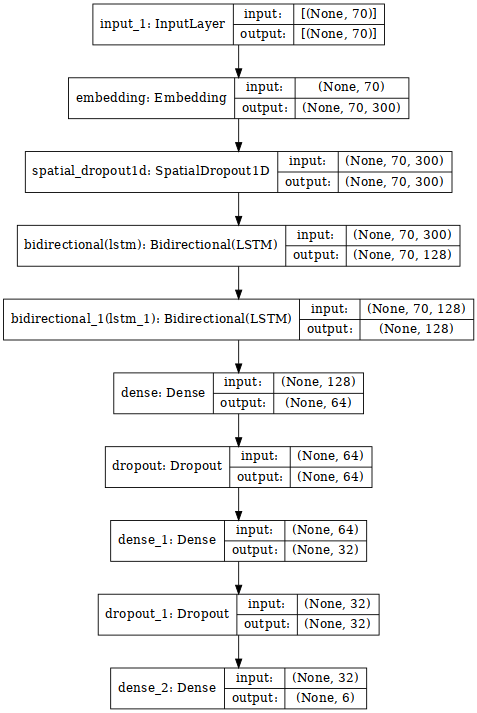

In [30]:
tf.keras.utils.plot_model(model1, show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=64,
    layer_range=False)

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

model1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              metrics=['accuracy'])
start_time = time.time()

history1 = model1.fit( 
    train_gen,
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=val_steps,
    #class_weight=weights,
    callbacks=[early_stop,reducelr],verbose=1)
end_time = time.time()

Epoch 1/50
10100/10100 [==============================] - 667s 65ms/step - loss: 1.0815 - accuracy: 0.6079 - val_loss: 0.9497 - val_accuracy: 0.6563
Epoch 2/50
10100/10100 [==============================] - 657s 65ms/step - loss: 0.9632 - accuracy: 0.6589 - val_loss: 0.8875 - val_accuracy: 0.6837
Epoch 3/50
10100/10100 [==============================] - 657s 65ms/step - loss: 0.9080 - accuracy: 0.6820 - val_loss: 0.8451 - val_accuracy: 0.7032
Epoch 4/50
10100/10100 [==============================] - 657s 65ms/step - loss: 0.8727 - accuracy: 0.6963 - val_loss: 0.8211 - val_accuracy: 0.7094
Epoch 5/50
10100/10100 [==============================] - 657s 65ms/step - loss: 0.8492 - accuracy: 0.7054 - val_loss: 0.8033 - val_accuracy: 0.7159
Epoch 6/50
10100/10100 [==============================] - 657s 65ms/step - loss: 0.8327 - accuracy: 0.7119 - val_loss: 0.7915 - val_accuracy: 0.7221
Epoch 7/50
10100/10100 [==============================] - 657s 65ms/step - loss: 0.8181 - accuracy: 0.7161

In [38]:
execution_time = end_time - start_time

# Afișează timpul de execuție
print("Timpul de execuție:", execution_time, "secunde")

Timpul de execuție: 9859.871963977814 secunde


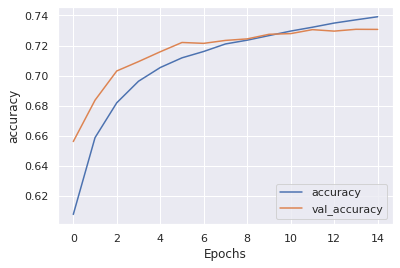

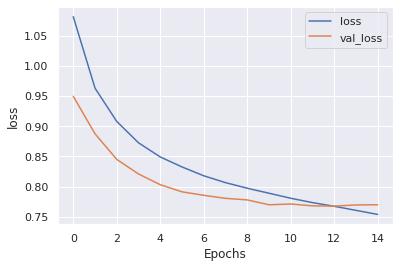

In [39]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history1, "accuracy")
plot_graphs(history1, "loss")

In [40]:
# model1.save('./model_lstm_tokenization_aftercorrect')

In [41]:
# Make predictions on the test data
y_pred = model1.predict(test_padded)


In [42]:
from sklearn.metrics import classification_report

# Convert predictions to labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true labels
y_true_labels =test_label_seq

test_label_text = encoder.inverse_transform(y_true_labels)
pred_label_text = encoder.inverse_transform(y_pred_labels)

# Print the classification report
print(classification_report(test_label_text, pred_label_text))

               precision    recall  f1-score   support

      Anxiety       0.77      0.83      0.80     48272
          BPD       0.80      0.78      0.79     63520
      bipolar       0.70      0.56      0.63     10626
   depression       0.61      0.77      0.68     35949
mentalillness       0.53      0.14      0.22     11311
schizophrenia       0.60      0.43      0.50      3467

     accuracy                           0.73    173145
    macro avg       0.67      0.59      0.60    173145
 weighted avg       0.73      0.73      0.72    173145



<AxesSubplot:>

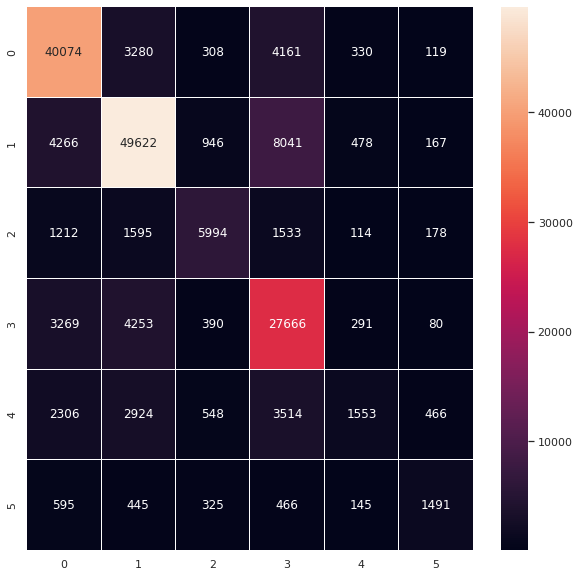

In [43]:
cm=confusion_matrix(test_label_text,pred_label_text)
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(cm, annot=True, linewidths = 0.01,ax=ax, fmt='g')